## IL PROGETTO

- Il nostro progetto si focalizza sull'uso di un modello di Natural Language Processing (NLP) pre-trained per analizzare descrizioni delle classi di Dungeons and Dragons (D&D) presenti in file specifici. Implementiamo un sistema di Question and Answering (Q&A) che consente agli utenti di porre domande sulle informazioni delle classi e ricevere risposte accurate, introduciamo inolte anche la traduzione automatica dall'inglese all'italiano.Il processo coinvolge l'impiego di modelli di recupero e di lettura, insieme a tecniche di embedding per migliorare la comprensione del contesto e fornire risposte più precise.

# NLP (Natural Language Processing)

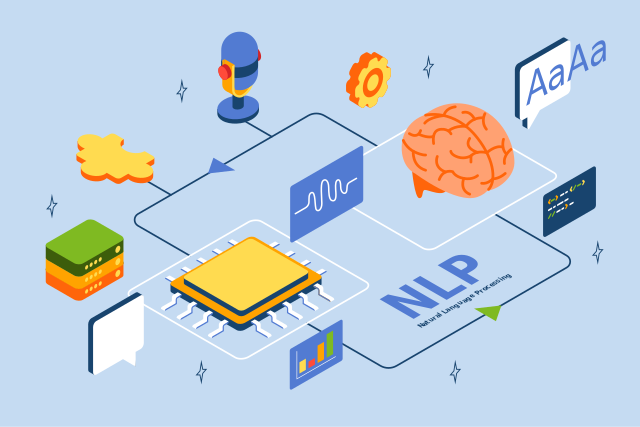

- Tokenizzazione: Il testo viene diviso in unità più piccole chiamate token, che possono essere parole o frasi.

- Analisi morfologica: Vengono analizzate le forme delle parole per comprendere la loro struttura e significato.

- Analisi sintattica: Si analizza la struttura grammaticale delle frasi per comprendere le relazioni tra le parole.

- Analisi semantica: Si cerca di comprendere il significato delle parole e delle frasi nel contesto.

- Disambiguazione semantica: Risolve ambiguità nel significato delle parole basandosi sul contesto.

- Rappresentazione del testo: Il testo viene convertito in una forma comprensibile per la macchina, spesso sotto forma di vettori numerici.

- Apprendimento automatico: I modelli NLP utilizzano algoritmi di apprendimento automatico per migliorare la comprensione del linguaggio e adattarsi a nuovi dati.

- Risposta e generazione di testo: La macchina è in grado di rispondere a domande, generare testo o compiere azioni basate sulla comprensione del linguaggio.

In [4]:
from haystack.document_stores import InMemoryDocumentStore
from haystack.pipelines import Pipeline, ExtractiveQAPipeline
from haystack.nodes import DensePassageRetriever, TextConverter, PreProcessor, FARMReader
from haystack.utils import print_answers
from haystack import document_stores
from transformers import MBartForConditionalGeneration, MBart50TokenizerFast
import os

Creazione del Document Store

In [5]:
doc_store = InMemoryDocumentStore()

In [6]:
# Configurazione del Retriever:
retriever = DensePassageRetriever(document_store=doc_store)

c:\Users\Max\anaconda3\Lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [7]:
text_converter = TextConverter()

In [8]:
preprocessor = PreProcessor(
    split_length=200,
    split_overlap=100
)

In [9]:
pipe = Pipeline()

Creazione della pipe

In [10]:

pipe.add_node(component=text_converter, name="converter", inputs=["File"])
pipe.add_node(component=preprocessor, name="preprocessor", inputs=["converter"])
pipe.add_node(component=doc_store, name="store", inputs=["preprocessor"])

In [11]:

folder_name = "data\DnD Classes"
file_paths = [os.path.join(folder_name, filename) for filename in os.listdir(folder_name)]

pipe.run(file_paths=file_paths)

Preprocessing: 100%|██████████| 6/6 [00:00<00:00, 20.26docs/s]


{'documents': [<Document: {'content': "Class - Fighter\n\nLevel 1 - Fighting Style: You adopt a particular style of fighting as your specialty. Choose one of the following options: Archery, Defense, Dueling, Great Weapon Fighting, Protection, Two-Weapon Fighting. You can't take the same Fighting Style option more than once, even if you get to choose again.; Second Wind: You have a limited well of stamina that you can draw on to protect yourself from harm. On your turn, you can use a bonus action to regain hit points equal to 1d10 + your fighter level. Once you use this feature, you must finish a short or long rest before you can use it again.\n\nLevel 2 - Action Surge: Starting at 2nd level, you can push yourself beyond your normal limits for a moment. On your turn, you can take one additional action. Once you use this feature, you must finish a short or long rest before you can use it again. Starting at 17th level, you can use it twice before a rest, but only once on the same turn.\n\

In [12]:
for doc in doc_store.get_all_documents_generator():
    print(doc)
    break

<Document: id=1d1625192fe6e5e8d9886e9ea552f4ff, content='Class - Fighter

Level 1 - Fighting Style: You adopt a particular style of fighting as your specialt...'>


In [13]:
len(doc_store.get_all_documents())

673

# Embedding

![Embeddings models.PNG](<attachment:Embeddings models.PNG>)
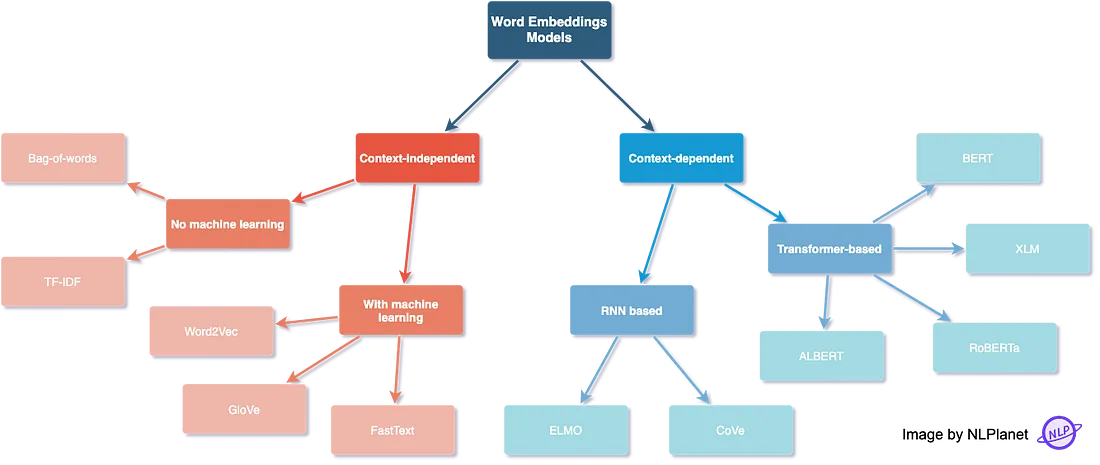

Gli embedding vengono calcolati per i documenti utilizzando il retriever.

In [14]:
doc_store.update_embeddings(retriever=retriever)

Updating Embedding:   0%|          | 0/673 [00:00<?, ? docs/s]

Documents Processed: 10000 docs [02:10, 76.67 docs/s]          


In [15]:
reader = FARMReader(model_name_or_path="deepset/roberta-base-squad2", return_no_answer=False, top_k=100)

In [16]:
pipe_qa = ExtractiveQAPipeline(reader=reader, retriever=retriever)

In [17]:
ans = pipe_qa.run(query="What does the fighter get at level 2?", params={"Retriever": {"top_k": 20}})

Inferencing Samples: 100%|██████████| 1/1 [00:06<00:00,  6.35s/ Batches]


#### Dettagli delle risposte

In [18]:
answer = ans["answers"][0]
print(answer.answer)

Action Surge


In [19]:
context = ans["answers"][0]
print(context.context)

 finish a short or long rest before you can use it again.

Level 2 - Action Surge: Starting at 2nd level, you can push yourself beyond your normal lim


In [23]:
#Traduzione della risposta da inglese a italiano

answer_en = str(answer.answer).lower()

model = MBartForConditionalGeneration.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")
tokenizer = MBart50TokenizerFast.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")

# translate the text
tokenizer.src_lang = "en_XX"
encoded_en = tokenizer(answer_en, return_tensors="pt")
generated_tokens = model.generate(
    **encoded_en,
    forced_bos_token_id=tokenizer.lang_code_to_id["it_IT"]
)
answer_it = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)



In [27]:
print(f"Testo in inglese: {answer_en} | Testo tradotto in italiano: {answer_it[0]}")

Testo in inglese: action surge | Testo tradotto in italiano: L'influenza dell'azione


In [22]:
# Print delle altre possibili risposte con il relativo score
print_answers(ans, details="medium")

'Query: What does the fighter get at level 2?'
'Answers:'
[   {   'answer': 'Action Surge',
        'context': ' finish a short or long rest before you can use it again.\n'
                   '\n'
                   'Level 2 - Action Surge: Starting at 2nd level, you can '
                   'push yourself beyond your normal lim',
        'score': 0.8476799726486206},
    {   'answer': 'bonus action',
        'context': 'vel, your quick thinking and agility grant you the ability '
                   'to take a bonus action during each of your turns in '
                   'combat. This bonus action can be employ',
        'score': 0.24924114346504211},
    {   'answer': '2d6',
        'context': 'her Levels. The spell’s damage increases by 1d6 when you '
                   'reach 5th level (2d6), 11th level (3d6), and 17th level '
                   '(4d6).\n'
                   '\n'
                   'Green-Flame Blade - Classes: ',
        'score': 0.06829115003347397},
    {   'ans